In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
path='/content/drive/My Drive/Colab Notebooks/Skin Cancer/hmnist_28_28_RGB.csv'


In [4]:
df=pd.read_csv(path)

In [5]:
df.tail()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,168,182,181,157,162,205,179,188,221,199,214,224,202,215,226,201,205,223,198,206,230,207,219,228,201,211,229,203,210,223,...,225,197,195,222,193,193,228,199,202,231,202,204,227,203,206,230,211,219,231,217,223,222,204,207,202,179,180,205,180,181,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,111,107,130,108,104,136,112,111,148,125,125,155,132,134,157,132,132,164,138,137,187,161,161,198,172,173,202,175,175,209,...,207,179,179,195,164,162,197,168,169,203,176,180,192,165,165,188,162,162,184,162,164,185,162,163,161,137,135,155,132,129,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,164,167,195,173,175,210,191,199,212,195,201,210,189,193,218,194,203,217,191,195,217,195,199,224,201,203,236,211,215,250,...,200,169,165,217,183,179,241,211,210,242,216,215,239,214,213,234,208,208,224,198,196,206,180,177,226,202,201,214,192,190,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,124,142,173,134,149,177,139,156,181,141,159,183,137,154,185,139,160,185,145,165,186,148,162,189,157,170,190,155,169,191,...,189,141,159,192,167,179,193,173,183,192,171,181,190,164,171,190,162,171,190,168,179,194,177,187,192,170,180,186,163,165,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,145,127,177,144,122,177,146,123,179,148,126,185,157,140,177,142,113,174,138,112,177,141,117,175,139,108,178,145,117,181,...,183,150,136,178,141,116,184,151,135,188,160,147,183,153,131,180,146,131,173,137,115,157,88,68,146,32,47,145,24,48,159,79,82,174,137,125,175,139,126,6


In [7]:
#reference https://github.com/rohanmandrekar/Cifar-10-/blob/master/best_attempt%28model7%29.ipynb

fractions=np.array([0.8,0.2])
df=df.sample(frac=1)
train_set, test_set = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [9]:
print(len(train_set))

8012


In [10]:
print(len(test_set))

2003


In [11]:
df.label.unique()

array([4, 6, 1, 3, 2, 0, 5])

In [12]:
# reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
classes={0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),
         1:('bcc' , 'basal cell carcinoma'),
         2:('bkl', 'benign keratosis-like lesions'),
         3:('df', 'dermatofibroma'),
         4:('nv', ' melanocytic nevi'),
         5:('vasc', ' pyogenic granulomas and hemorrhage'),
         6:('mel', 'melanoma'),}

In [38]:
y_train=train_set['label']
x_train=train_set.drop(columns=['label'])
y_test=test_set['label']
x_test=test_set.drop(columns=['label'])

columns=list(x_train)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


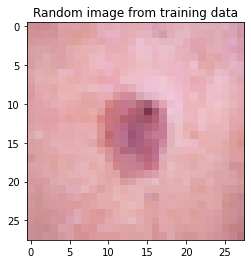

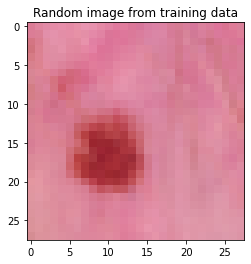

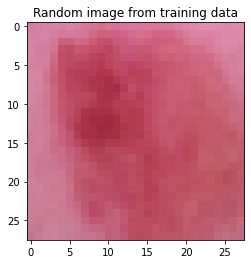

In [52]:
import matplotlib.pyplot as plt
import random
num=random.randint(0,8000)
x_train=np.array(x_train, dtype=np.uint8).reshape(-1,28,28,3)

plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()
num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

In [61]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.RandomVerticalFlip(p=1),
     transforms.RandomRotation(degrees = 45),
     transforms.RandomPerspective(distortion_scale=0.5, p=0.5,fill=0)
     ])

In [64]:

print(x_train.shape)

trainloader= torch.utils.data.DataLoader(x_train, batch_size=4)

(8012, 28, 28, 3)


In [84]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.Conv1=nn.Conv2d(3,56,5)
    self.Pool=nn.MaxPool2d(2,2)
    self.Conv2=nn.Conv2d(56,112,5)
    self.FC1=nn.Linear(112*5*5,1400)
    self.FC2=nn.Linear(1400,700)
    self.FC3=nn.Linear(700,350)
    self.FC4=nn.Linear(350,175)
    self.FC5=nn.Linear(175,80)
    self.FC6=nn.Linear(80,30)
    self.FC7=nn.Linear(30,7)
    self.Drop=nn.Dropout(p=0.1)

  def forward(self,x):
    x = self.Pool(F.relu(self.Conv1(x)))
    x = self.Cool(F.relu(self.Conv2(x)))
    x = x.view(-1, 112*5*5)
    x = F.relu(self.FC1(x))
    x = F.relu(self.FC2(x))
    x = F.relu(self.FC3(x))
    x = self.drop(x)
    x = F.relu(self.FC4(x))
    x = F.relu(self.FC5(x))
    x = self.dropout(x)
    x = F.relu(self.FC6(x))
    x = self.FC7(x)
    return x

model=Model()
model=model.to(device)
print(model)


Model(
  (Conv1): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1))
  (Pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(56, 112, kernel_size=(5, 5), stride=(1, 1))
  (FC1): Linear(in_features=2800, out_features=1400, bias=True)
  (FC2): Linear(in_features=1400, out_features=700, bias=True)
  (FC3): Linear(in_features=700, out_features=350, bias=True)
  (FC4): Linear(in_features=350, out_features=175, bias=True)
  (FC5): Linear(in_features=175, out_features=80, bias=True)
  (FC6): Linear(in_features=80, out_features=30, bias=True)
  (FC7): Linear(in_features=30, out_features=7, bias=True)
  (Drop): Dropout(p=0.1, inplace=False)
)


In [82]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [99]:
for epoch in range(50):
  i=0
  running_loss = 0.0
  total_train = 0
  correct_train = 0
  for img in x_train:
    optimizer.zero_grad()
    
    img=torchvision.transforms.functional.to_pil_image(img)
    img=torch.from_numpy(np.array(img))
    output=model(img.unsqueeze(1).reshape(1,3,28,28))
    loss=criterion(output,y_train[i])
    loss.backward()
    optimizer.step()

    running_loss=running_loss+loss.item()

    _, predicted = torch.max(output.data, 1)
    total_train += y_train[i].size(0)
    correct_train += predicted.eq(y_train[i]).sum().item()
    train_accuracy = 100 * correct_train / total_train

    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
      (epoch + 1, i + 1, running_loss / 2000))
      print("training accuracy : ",train_accuracy)
      running_loss = 0.0

print('Finished Training')


RuntimeError: ignored